# 원본 파일 받고 HDFS에 복사

In [1]:
# 샘플 데이터 다운로드
!wget 'http://criteolabs.wpengine.com/wp-content/uploads/2015/04/dac_sample.tar.gz'

--2016-11-30 01:04:59--  http://criteolabs.wpengine.com/wp-content/uploads/2015/04/dac_sample.tar.gz
Resolving criteolabs.wpengine.com (criteolabs.wpengine.com)... 162.13.141.181
Connecting to criteolabs.wpengine.com (criteolabs.wpengine.com)|162.13.141.181|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8787154 (8.4M) [application/octet-stream]
Saving to: ‘dac_sample.tar.gz.1’

dac_sample.tar.gz.1 100%[===================>]   8.38M  1.12MB/s    in 8.1s    

2016-11-30 01:05:08 (1.04 MB/s) - ‘dac_sample.tar.gz.1’ saved [8787154/8787154]



In [2]:
# 압축 풀기
!tar xzvf dac_sample.tar.gz

tar: Ignoring unknown extended header keyword `LIBARCHIVE.creationtime'
tar: Ignoring unknown extended header keyword `SCHILY.dev'
tar: Ignoring unknown extended header keyword `SCHILY.ino'
tar: Ignoring unknown extended header keyword `SCHILY.nlink'
dac_sample.txt
tar: Ignoring unknown extended header keyword `SCHILY.dev'
tar: Ignoring unknown extended header keyword `SCHILY.ino'
tar: Ignoring unknown extended header keyword `SCHILY.nlink'
./._readme.txt
tar: Ignoring unknown extended header keyword `SCHILY.dev'
tar: Ignoring unknown extended header keyword `SCHILY.ino'
tar: Ignoring unknown extended header keyword `SCHILY.nlink'
readme.txt
tar: Ignoring unknown extended header keyword `SCHILY.dev'
tar: Ignoring unknown extended header keyword `SCHILY.ino'
tar: Ignoring unknown extended header keyword `SCHILY.nlink'
license.txt


In [3]:
# HDFS에 복사
!hadoop fs -cp file:/home/hadoop/works/dac_sample.txt hdfs:/user/hadoop/dac_sample.txt

# 원본 DataFrame 만들기

In [4]:
# 텍스트 파일 로드하여 Text RDD 생성
text_rdd = sc.textFile('hdfs:/user/hadoop/dac_sample.txt')

In [5]:
# DataFrame의 스키마
from pyspark.sql.types import *

fields = [StructField("label", IntegerType(), False),
          StructField("features", ArrayType(StringType()), False)
         ]
schema = StructType(fields)

In [6]:
# 파싱하여 DataFrame 생성
def parse(l):
    elm = l.split('\t')
    return int(elm[0]), ["{}: {}".format(i, e) for i, e in enumerate(elm[1:])]

raw_df = text_rdd.map(parse).toDF(schema)
raw_df.cache()

DataFrame[label: int, features: array<string>]

In [7]:
raw_df.take(1)

[Row(label=0, features=['0: 1', '1: 1', '2: 5', '3: 0', '4: 1382', '5: 4', '6: 15', '7: 2', '8: 181', '9: 1', '10: 2', '11: ', '12: 2', '13: 68fd1e64', '14: 80e26c9b', '15: fb936136', '16: 7b4723c4', '17: 25c83c98', '18: 7e0ccccf', '19: de7995b8', '20: 1f89b562', '21: a73ee510', '22: a8cd5504', '23: b2cb9c98', '24: 37c9c164', '25: 2824a5f6', '26: 1adce6ef', '27: 8ba8b39a', '28: 891b62e7', '29: e5ba7672', '30: f54016b9', '31: 21ddcdc9', '32: b1252a9d', '33: 07b5194c', '34: ', '35: 3a171ecb', '36: c5c50484', '37: e8b83407', '38: 9727dd16'])]

In [54]:
# Train, Validation, Test 셋 분리
weights = [.8, .1, .1]
seed = 42
raw_train_df, raw_valid_df, raw_test_df = raw_df.randomSplit(weights, seed=seed)

# One Hot Encoding을 위한 사전 만들기 

In [9]:
from pyspark.sql import functions as F

# 전체 데이터의 Feature를 대상으로 One Hot Encoding 사전 만듦
ohe_dict = raw_df.select(F.explode(raw_df.features)).distinct().rdd.map(lambda r: str(r[0])).zipWithIndex().collectAsMap()

In [10]:
# 수행시간 최적화를 위해 OHE 사전을 Broadcast
ohe_dict_bc = sc.broadcast(ohe_dict)

In [11]:
# 주의: mllib이 아닌 ml의 SparseVector
from pyspark.ml.linalg import SparseVector

# OHE 함수
#   메모리를 절약하기 위해 SparseVector 사용
def one_hot_encoding(raw_feats, dict_bc, num_feats):
    indices = sorted([dict_bc.value[feat] for feat in raw_feats])
    return SparseVector(num_feats, indices, [1] * len(indices))

In [12]:
from pyspark.ml.linalg import VectorUDT

# OHE UDF 함수를 생성기
#   One Hot Encoding의 결과(SparseVector)는 VectorUDT(User Defined Type)형으로 SQL측에 반환해야 함
def ohe_udf_gen(dict_bc):
    length = len(dict_bc.value)
    return F.udf(lambda x: one_hot_encoding(x, dict_bc, length), VectorUDT())

In [13]:
# OHE UDF 함수 생성
ohe_dict_udf = ohe_udf_gen(ohe_dict_bc)

# 사전을 통해 One Hot Encoding된 Feature 만들기

In [14]:
# label은 DoubleType이어야 하기에 cast
ohe_train_df = raw_train_df.select(F.col('label').cast('double'), 
                                   ohe_dict_udf(F.col('features')).alias('features'))
ohe_train_df.cache()

DataFrame[label: double, features: vector]

In [15]:
ohe_valid_df = raw_valid_df.select(F.col('label').cast('double'), 
                                   ohe_dict_udf(F.col('features')).alias('features'))
ohe_valid_df.cache()

DataFrame[label: double, features: vector]

In [16]:
ohe_test_df = raw_test_df.select(F.col('label').cast('double'), 
                                 ohe_dict_udf(F.col('features')).alias('features'))
ohe_test_df.cache()

DataFrame[label: double, features: vector]

# Logistic Regression 학습

In [60]:
from pyspark.ml.classification import LogisticRegression

# Logistic Regression 객체 생성
#  elasticNetParam을 0으로 하면 RidgeRegressionWithSGD와 같아진다.
#  이 경우 coefficients가 DenseVector로 반환되기에 구현이 간단해 진다.
lr = LogisticRegression(standardization=False, elasticNetParam=0.0, 
                        regParam=.01, maxIter=20)

lr_model_basic = lr.fit(ohe_train_df.select(ohe_train_df.label, 
                                            ohe_train_df.features))

print('intercept: {0}'.format(lr_model_basic.intercept))
print('length of coefficients: {0}'.format(len(lr_model_basic.coefficients)))
sorted_coefficients = sorted(lr_model_basic.coefficients)[:5]

intercept: -1.2305792897509757
length of coefficients: 273531


In [64]:
# 학습된 모델의 coefficients의 수는 OHE Dict의 수, 즉 피쳐 수와 같다.
len(ohe_dict)

273531

# 학습된 모델을 통해 확률 추가하기

In [61]:
from pyspark.sql.types import DoubleType
from math import exp #  exp(-t) = e^-t

# DataFrame에 확률 컬럼 'p'를 추가한다.
def add_probability(df, model):
    # 학습된 모델의 계수와 절편을 얻어와 직접 적용
    coefficients_broadcast = sc.broadcast(model.coefficients)
    intercept = model.intercept

    def get_p(features):
        # 예측값 계산
        raw_prediction = intercept + features.dot(coefficients_broadcast.value)
        # 수치적 안정화를 위해 예측 값은 -20에서 20사이의 값으로 조정
        raw_prediction = max(min(raw_prediction, 20), -20)
        # Sigmoid함수로 0과 1사이의 확률 값으로 반환
        return 1. / (1 + exp(-raw_prediction))

    get_p_udf = F.udf(get_p, DoubleType())
    return df.withColumn('p', get_p_udf('features'))

add_probability_model_basic = lambda df: add_probability(df, lr_model_basic)
training_predictions = add_probability_model_basic(ohe_train_df).cache()

training_predictions.show(5)

+-----+--------------------+-------------------+
|label|            features|                  p|
+-----+--------------------+-------------------+
|  0.0|(273531,[8237,189...|0.15245690119029345|
|  0.0|(273531,[8237,189...|0.15116321092905766|
|  0.0|(273531,[8237,189...| 0.1656905342059713|
|  0.0|(273531,[2152,414...| 0.1297898533950584|
|  0.0|(273531,[8237,177...|0.19090817079787498|
+-----+--------------------+-------------------+
only showing top 5 rows



# ROC 커브 그려보기

In [65]:
# Plot 레이아웃 준비
def prepare_plot(xticks, yticks, figsize=(10.5, 6), hide_labels=False, grid_color='#999999',
                 grid_width=1.0):
    plt.close()
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.axes.tick_params(labelcolor='#999999', labelsize='10')
    for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
        axis.set_ticks_position('none')
        axis.set_ticks(ticks)
        axis.label.set_color('#999999')
        if hide_labels: axis.set_ticklabels([])
    plt.grid(color=grid_color, linewidth=grid_width, linestyle='-')
    map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])
    return fig, ax

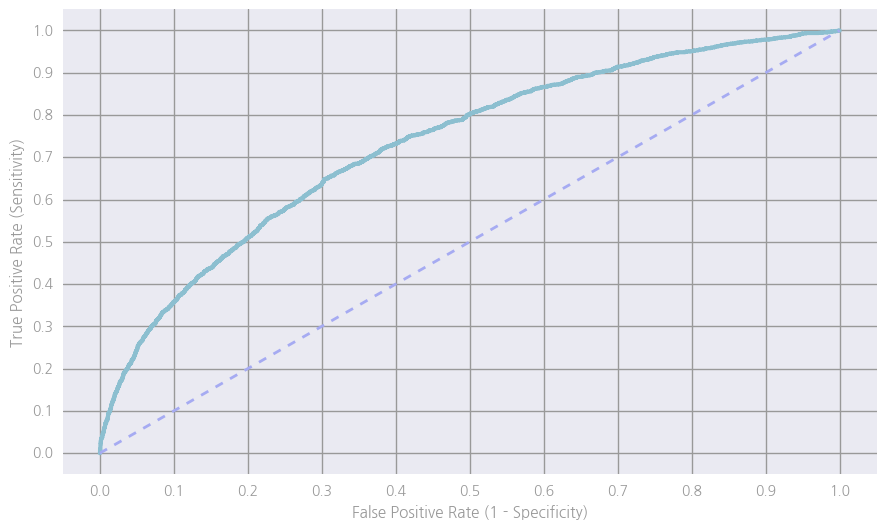

In [66]:
# ROC 그리기
labels_and_scores = add_probability_model_basic(ohe_valid_df).select('label', 'p')
labels_and_weights = labels_and_scores.collect()
labels_and_weights.sort(key=lambda kv: kv[1], reverse=True)
labels_by_weight = np.array([k for (k, v) in labels_and_weights])

length = labels_by_weight.size
true_positives = labels_by_weight.cumsum()
num_positive = true_positives[-1]
false_positives = np.arange(1.0, length + 1, 1.) - true_positives

true_positive_rate = true_positives / num_positive
false_positive_rate = false_positives / (length - num_positive)

fig, ax = prepare_plot(np.arange(0., 1.1, 0.1), np.arange(0., 1.1, 0.1))
ax.set_xlim(-.05, 1.05), ax.set_ylim(-.05, 1.05)
ax.set_ylabel('True Positive Rate (Sensitivity)')
ax.set_xlabel('False Positive Rate (1 - Specificity)')
plt.plot(false_positive_rate, true_positive_rate, color='#8cbfd0', linestyle='-', linewidth=3.)
plt.plot((0., 1.), (0., 1.), linestyle='--', color='#a6abf2', linewidth=2.)  # Baseline model

# 예측 결과

In [67]:
labels_and_scores = add_probability_model_basic(ohe_test_df).select('label', 'p')
labels_and_weights = labels_and_scores.collect()
labels_and_weights.sort(key=lambda kv: kv[1], reverse=True)
n_sample = float(len(labels_and_weights))
n_right = len([1 for lw in labels_and_weights if (lw.p >= 0.5 and lw.label == 1.0) or (lw.p < 0.5 and lw.label == 0.0)])
print("Accuracy: {}".format(n_right / n_sample))

Accuracy: 0.784398590840463
